In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from datetime import datetime

%matplotlib inline

# Impor the OpenWeatherMap API key
from config import api_key


In [3]:
#Variables used in API call, oldest date is furthest back we are willing to go
oldest_date = "2014-01-31"
company_symbols = ["TAN",
                    "ENPH",
                    "SEDG",
                    "FSLR",
                    "HYDR",
                    "PLUG",
                    "BLDP",
                    "BE",
                    "FAN",
                    "TAC",
                    "TPIC",
                    "AMSC"]
time_function = "TIME_SERIES_MONTHLY"
base_url = "https://www.alphavantage.co/query?"

company_data = []

for symbol in company_symbols:
    finished_url = f"{base_url}function={time_function}&symbol={symbol}&apikey={api_key}"
    print(f"Processing {symbol}")

    result_data = requests.get(finished_url).json()
    print(result_data)

    time.sleep(12)

    for monthly in result_data["Monthly Time Series"]:
        monthly_date = time.strptime(monthly, "%Y-%m-%d")
        oldest = time.strptime(oldest_date, "%Y-%m-%d")
        if (monthly_date < oldest):
            continue
        stock_date = monthly
        stock_close = result_data["Monthly Time Series"][monthly]["4. close"]
        company_data.append({"Symbol":symbol,
                            "Date":stock_date,
                            "Closing Price":stock_close})

company_data_df = pd.DataFrame(company_data)
company_data_df.head()


Processing TAN
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'TAN', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '41.2400', '2. high': '43.1400', '3. low': '37.3300', '4. close': '40.6600', '5. volume': '15406103'}, '2024-08-30': {'1. open': '42.4800', '2. high': '43.1700', '3. low': '37.4200', '4. close': '41.2800', '5. volume': '17518322'}, '2024-07-31': {'1. open': '40.0100', '2. high': '44.7400', '3. low': '38.6800', '4. close': '42.1300', '5. volume': '27008279'}, '2024-06-28': {'1. open': '49.4000', '2. high': '49.9300', '3. low': '40.0100', '4. close': '40.2100', '5. volume': '22797496'}, '2024-05-31': {'1. open': '40.1200', '2. high': '49.4900', '3. low': '40.1200', '4. close': '48.2800', '5. volume': '30699120'}, '2024-04-30': {'1. open': '45.2800', '2. high': '45.8950', '3. low': '38.8300', '4. close': '40.3300', '5. volume': '28546574'}, '2024-03-28':

Processing ENPH
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'ENPH', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '118.6300', '2. high': '126.1900', '3. low': '100.4800', '4. close': '114.9000', '5. volume': '35751580'}, '2024-08-30': {'1. open': '115.7700', '2. high': '130.0800', '3. low': '96.7800', '4. close': '121.0400', '5. volume': '50652623'}, '2024-07-31': {'1. open': '99.5000', '2. high': '122.9500', '3. low': '95.2100', '4. close': '115.1100', '5. volume': '100529131'}, '2024-06-28': {'1. open': '131.2100', '2. high': '141.6300', '3. low': '98.3700', '4. close': '99.7100', '5. volume': '73553918'}, '2024-05-31': {'1. open': '109.0500', '2. high': '134.0000', '3. low': '102.3400', '4. close': '127.9000', '5. volume': '88718966'}, '2024-04-30': {'1. open': '121.3300', '2. high': '127.6700', '3. low': '98.4000', '4. close': '108.7600', '5. volume': '9197

Processing SEDG
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'SEDG', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '23.8100', '2. high': '23.9900', '3. low': '17.1200', '4. close': '20.3700', '5. volume': '57507926'}, '2024-08-30': {'1. open': '29.0400', '2. high': '31.0700', '3. low': '19.8060', '4. close': '24.3300', '5. volume': '80186193'}, '2024-07-31': {'1. open': '25.0300', '2. high': '32.1100', '3. low': '23.5100', '4. close': '28.8600', '5. volume': '117356832'}, '2024-06-28': {'1. open': '50.6000', '2. high': '50.8300', '3. low': '24.4400', '4. close': '25.2600', '5. volume': '91789177'}, '2024-05-31': {'1. open': '58.8000', '2. high': '64.0400', '3. low': '46.8600', '4. close': '48.9900', '5. volume': '53197746'}, '2024-04-30': {'1. open': '71.2700', '2. high': '73.6000', '3. low': '53.5900', '4. close': '58.6500', '5. volume': '39818594'}, '2024-03-2

Processing FSLR
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'FSLR', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '226.6500', '2. high': '251.6699', '3. low': '202.1500', '4. close': '240.2000', '5. volume': '28712010'}, '2024-08-30': {'1. open': '219.1000', '2. high': '244.2100', '3. low': '195.2700', '4. close': '227.3700', '5. volume': '36183666'}, '2024-07-31': {'1. open': '224.7500', '2. high': '240.9600', '3. low': '206.8500', '4. close': '215.9900', '5. volume': '61612654'}, '2024-06-28': {'1. open': '273.2600', '2. high': '306.7699', '3. low': '225.1200', '4. close': '225.4600', '5. volume': '59876199'}, '2024-05-31': {'1. open': '176.6100', '2. high': '286.6000', '3. low': '172.0900', '4. close': '271.7600', '5. volume': '78128648'}, '2024-04-30': {'1. open': '169.7200', '2. high': '188.3200', '3. low': '162.1600', '4. close': '176.3000', '5. volume': 

Processing HYDR
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'HYDR', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '23.8400', '2. high': '24.8200', '3. low': '22.2900', '4. close': '23.7400', '5. volume': '210461'}, '2024-08-30': {'1. open': '26.7500', '2. high': '26.9100', '3. low': '23.0000', '4. close': '24.0900', '5. volume': '370420'}, '2024-07-31': {'1. open': '26.5600', '2. high': '30.4200', '3. low': '25.5500', '4. close': '26.7800', '5. volume': '470026'}, '2024-06-28': {'1. open': '6.8200', '2. high': '28.8299', '3. low': '5.7100', '4. close': '26.1400', '5. volume': '1734881'}, '2024-05-31': {'1. open': '5.1900', '2. high': '6.9300', '3. low': '5.1600', '4. close': '6.6800', '5. volume': '2378971'}, '2024-04-30': {'1. open': '5.7000', '2. high': '5.9700', '3. low': '4.8500', '4. close': '5.2200', '5. volume': '1510678'}, '2024-03-28': {'1. open': '5.4

Processing BLDP
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'BLDP', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '1.8200', '2. high': '1.8400', '3. low': '1.6100', '4. close': '1.6700', '5. volume': '40353827'}, '2024-08-30': {'1. open': '2.2900', '2. high': '2.3050', '3. low': '1.7700', '4. close': '1.8400', '5. volume': '58930515'}, '2024-07-31': {'1. open': '2.2700', '2. high': '2.7100', '3. low': '2.1418', '4. close': '2.2800', '5. volume': '55778931'}, '2024-06-28': {'1. open': '3.1200', '2. high': '3.1550', '3. low': '2.2200', '4. close': '2.2500', '5. volume': '47806717'}, '2024-05-31': {'1. open': '2.6400', '2. high': '3.3353', '3. low': '2.5900', '4. close': '3.0900', '5. volume': '56360621'}, '2024-04-30': {'1. open': '3.1300', '2. high': '3.3800', '3. low': '2.4200', '4. close': '2.6300', '5. volume': '72254595'}, '2024-03-28': {'1. open': '3.0800',

Processing BE
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'BE', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '11.5700', '2. high': '11.7200', '3. low': '9.4250', '4. close': '10.9100', '5. volume': '72914612'}, '2024-08-30': {'1. open': '13.5900', '2. high': '13.7200', '3. low': '9.8200', '4. close': '11.9100', '5. volume': '105183317'}, '2024-07-31': {'1. open': '12.3200', '2. high': '17.2250', '3. low': '10.6450', '4. close': '13.5400', '5. volume': '127054850'}, '2024-06-28': {'1. open': '16.8900', '2. high': '17.0000', '3. low': '12.0800', '4. close': '12.2400', '5. volume': '110522994'}, '2024-05-31': {'1. open': '11.1300', '2. high': '18.1400', '3. low': '11.0500', '4. close': '16.3200', '5. volume': '201966308'}, '2024-04-30': {'1. open': '11.7500', '2. high': '12.5100', '3. low': '9.1200', '4. close': '11.1300', '5. volume': '124648206'}, '2024-03-28':

Processing FAN
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'FAN', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '16.8700', '2. high': '17.8500', '3. low': '16.5401', '4. close': '17.7700', '5. volume': '452021'}, '2024-08-30': {'1. open': '16.9600', '2. high': '17.0800', '3. low': '16.0000', '4. close': '16.9850', '5. volume': '803833'}, '2024-07-31': {'1. open': '16.3500', '2. high': '17.2600', '3. low': '16.1400', '4. close': '17.0900', '5. volume': '1054843'}, '2024-06-28': {'1. open': '17.4400', '2. high': '17.6500', '3. low': '16.0800', '4. close': '16.2100', '5. volume': '677760'}, '2024-05-31': {'1. open': '15.2600', '2. high': '17.4900', '3. low': '15.1600', '4. close': '17.4400', '5. volume': '977561'}, '2024-04-30': {'1. open': '15.4100', '2. high': '15.6600', '3. low': '14.8000', '4. close': '15.3000', '5. volume': '722915'}, '2024-03-28': {'1. open'

Processing TAC
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'TAC', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '8.7500', '2. high': '9.9050', '3. low': '8.6000', '4. close': '9.8000', '5. volume': '8613928'}, '2024-08-30': {'1. open': '7.6500', '2. high': '9.0200', '3. low': '7.4000', '4. close': '8.8000', '5. volume': '18268693'}, '2024-07-31': {'1. open': '7.1200', '2. high': '7.5950', '3. low': '6.7800', '4. close': '7.5400', '5. volume': '14979508'}, '2024-06-28': {'1. open': '7.2300', '2. high': '7.3604', '3. low': '6.8200', '4. close': '7.0800', '5. volume': '14402118'}, '2024-05-31': {'1. open': '6.6900', '2. high': '7.3300', '3. low': '6.5800', '4. close': '7.2000', '5. volume': '19235221'}, '2024-04-30': {'1. open': '6.4500', '2. high': '6.8600', '3. low': '5.9400', '4. close': '6.6400', '5. volume': '19247699'}, '2024-03-28': {'1. open': '6.8600', '2

Processing TPIC
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'TPIC', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '4.2900', '2. high': '4.6500', '3. low': '3.3500', '4. close': '4.4200', '5. volume': '8947522'}, '2024-08-30': {'1. open': '4.3000', '2. high': '4.3500', '3. low': '2.9284', '4. close': '4.3300', '5. volume': '16074618'}, '2024-07-31': {'1. open': '3.9600', '2. high': '5.2600', '3. low': '3.4612', '4. close': '4.2600', '5. volume': '12222213'}, '2024-06-28': {'1. open': '5.6000', '2. high': '5.7500', '3. low': '3.8800', '4. close': '3.9900', '5. volume': '19427209'}, '2024-05-31': {'1. open': '3.2000', '2. high': '5.6600', '3. low': '3.1711', '4. close': '5.4800', '5. volume': '24263560'}, '2024-04-30': {'1. open': '2.9400', '2. high': '3.2800', '3. low': '2.2800', '4. close': '3.1800', '5. volume': '22610862'}, '2024-03-28': {'1. open': '2.7700', 

Processing AMSC
{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes', '2. Symbol': 'AMSC', '3. Last Refreshed': '2024-09-20', '4. Time Zone': 'US/Eastern'}, 'Monthly Time Series': {'2024-09-20': {'1. open': '19.5800', '2. high': '23.5900', '3. low': '17.9100', '4. close': '22.0300', '5. volume': '13917040'}, '2024-08-30': {'1. open': '24.2000', '2. high': '25.3199', '3. low': '17.0200', '4. close': '20.2200', '5. volume': '17227981'}, '2024-07-31': {'1. open': '23.5700', '2. high': '32.7000', '3. low': '22.1246', '4. close': '24.1600', '5. volume': '28252524'}, '2024-06-28': {'1. open': '20.0000', '2. high': '27.3800', '3. low': '19.2500', '4. close': '23.3900', '5. volume': '28780592'}, '2024-05-31': {'1. open': '12.4400', '2. high': '20.6866', '3. low': '12.3600', '4. close': '19.1800', '5. volume': '14110314'}, '2024-04-30': {'1. open': '13.6000', '2. high': '13.6300', '3. low': '11.3600', '4. close': '12.3500', '5. volume': '6028292'}, '2024-03-28'

,Symbol,Date,Closing Price
0,TAN,2024-09-20,40.6600
1,TAN,2024-08-30,41.2800
2,TAN,2024-07-31,42.1300
3,TAN,2024-06-28,40.2100
4,TAN,2024-05-31,48.2800


In [4]:
#Add a type column and lable to each stock
company_data_df["Type"] = ""
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "TAN", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "ENPH", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "SEDG", "Solar", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "FSLR", "Solar", company_data_df["Type"])

company_data_df["Type"] = np.where(company_data_df["Symbol"] == "HYDR", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "PLUG", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "BLDP", "Hydrogen", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "BE", "Hydrogen", company_data_df["Type"])

company_data_df["Type"] = np.where(company_data_df["Symbol"] == "FAN", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "TAC", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "TPIC", "Wind", company_data_df["Type"])
company_data_df["Type"] = np.where(company_data_df["Symbol"] == "AMSC", "Wind", company_data_df["Type"])

#Save the Data pulled to a CSV file
company_data_df.to_csv("data/company_data.csv", index_label="Stock_ID")

In [5]:
#Read data from the saved CSV file and sort it by symbol and date
read_data_df = pd.read_csv("data/company_data.csv", index_col="Stock_ID")
ordered_data_df = read_data_df.sort_values(by=["Symbol", "Date"])
ordered_data_df

,Symbol,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind
...,...,...,...,...
1133,TPIC,2024-05-31,5.48,Wind
1132,TPIC,2024-06-28,3.99,Wind
1131,TPIC,2024-07-31,4.26,Wind


In [6]:
print(ordered_data_df.columns)
# Define the stock symbols for each sector
solar_symbols = ["TAN", "ENPH", "SEDG", "FSLR"]
hydrogen_symbols = ["BLDP", "PLUG", "BE", "HYDR"]
wind_symbols = ["FAN", "TAC", "TPIC", "AMSC"]

#creating a data frame for each of the types
solar_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Solar']
solar_symbols_df.head()


Index(['Symbol', 'Date', 'Closing Price', 'Type'], dtype='object')


,Symbol,Date,Closing Price,Type
Stock_ID,,,,
257,ENPH,2014-01-31,7.40,Solar
256,ENPH,2014-02-28,8.07,Solar
255,ENPH,2014-03-31,7.36,Solar
254,ENPH,2014-04-30,7.55,Solar
253,ENPH,2014-05-30,8.45,Solar


In [7]:
#creating the wind data frames
wind_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Wind']
wind_symbols_df.head()


,Symbol,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind


In [8]:
hydrogen_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Hydrogen']
hydrogen_symbols_df.head()

,Symbol,Date,Closing Price,Type
Stock_ID,,,,
870,BE,2018-08-31,29.95,Hydrogen
869,BE,2018-09-28,34.08,Hydrogen
868,BE,2018-10-31,23.75,Hydrogen
867,BE,2018-11-30,16.45,Hydrogen
866,BE,2018-12-31,9.98,Hydrogen


C:\Users\16692\AppData\Local\Temp\ipykernel_113856\2288072558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_symbols_df['Returns'] = wind_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_113856\2288072558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_symbols_df['Volatility'] = wind_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


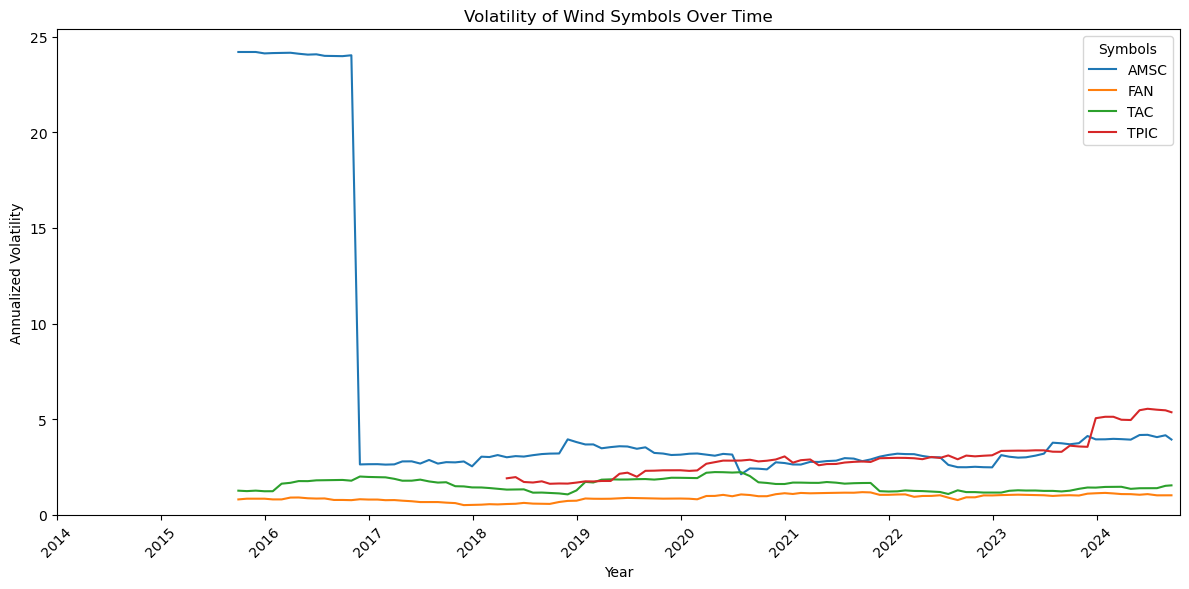

Symbol      AMSC  FAN  TAC  TPIC
Date                            
2014-01-31   NaN  NaN  NaN   NaN
2014-02-28   NaN  NaN  NaN   NaN
2014-03-31   NaN  NaN  NaN   NaN
2014-04-30   NaN  NaN  NaN   NaN
2014-05-30   NaN  NaN  NaN   NaN


In [23]:

# Calculate returns for each symbol
wind_symbols_df['Returns'] = wind_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
window = 20
wind_symbols_df['Volatility'] = wind_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = wind_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')

volatility_df.index = pd.to_datetime(volatility_df.index)

# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Wind Symbols Over Time')
plt.xlabel('Year')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.ylim(bottom=0)

years=mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax=plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.xlim(volatility_df.index.min() - pd.Timedelta(days=30),volatility_df.index.max() + pd.Timedelta(days=30))
plt.xticks(rotation=45)


plt.tight_layout()
#plt.grid(True)
plt.show()

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_line_plot.png')
#print("Plot saved as 'wind_symbols_volatility_line_plot.png'")

# Print the head of the volatility dataframe to check the data
print(volatility_df.head())

C:\Users\16692\AppData\Local\Temp\ipykernel_113856\3490490890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_symbols_df['Returns'] = solar_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_113856\3490490890.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_symbols_df['Volatility'] = solar_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


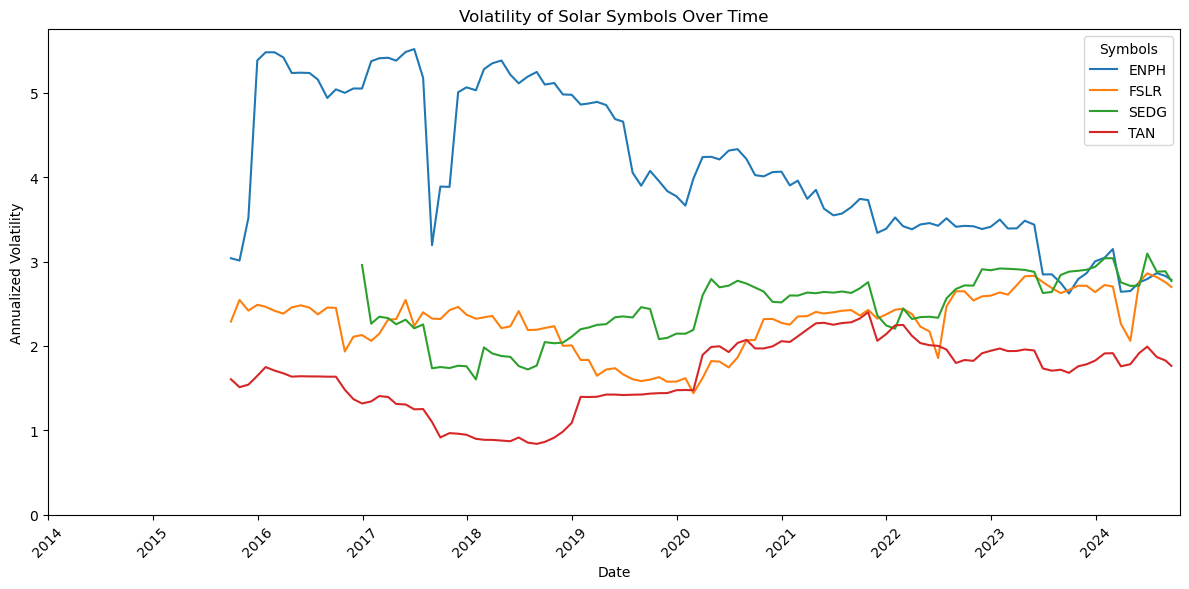

Symbol      ENPH  FSLR  SEDG  TAN
Date                             
2014-01-31   NaN   NaN   NaN  NaN
2014-02-28   NaN   NaN   NaN  NaN
2014-03-31   NaN   NaN   NaN  NaN
2014-04-30   NaN   NaN   NaN  NaN
2014-05-30   NaN   NaN   NaN  NaN


In [24]:
# Calculate returns for each symbol
solar_symbols_df['Returns'] = solar_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
window = 20
solar_symbols_df['Volatility'] = solar_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = solar_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')

volatility_df.index = pd.to_datetime(volatility_df.index)

# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Solar Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.ylim(bottom=0)

years=mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax=plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.xlim(volatility_df.index.min() - pd.Timedelta(days=30),volatility_df.index.max() + pd.Timedelta(days=30))
plt.xticks(rotation=45)

plt.tight_layout()

#plt.grid(True)

plt.show()

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_line_plot.png')
#print("Plot saved as 'wind_symbols_volatility_line_plot.png'")

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_plot.png')
#print("Plot saved as 'wind_symbols_volatility_plot.png'")

# Print the head of the volatility dataframe to check the data
print(volatility_df.head())

C:\Users\16692\AppData\Local\Temp\ipykernel_113856\1828266733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_symbols_df['Returns'] = hydrogen_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_113856\1828266733.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_symbols_df['Volatility'] = hydrogen_symbols_df.groupby('Symbol')['Returns'].std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


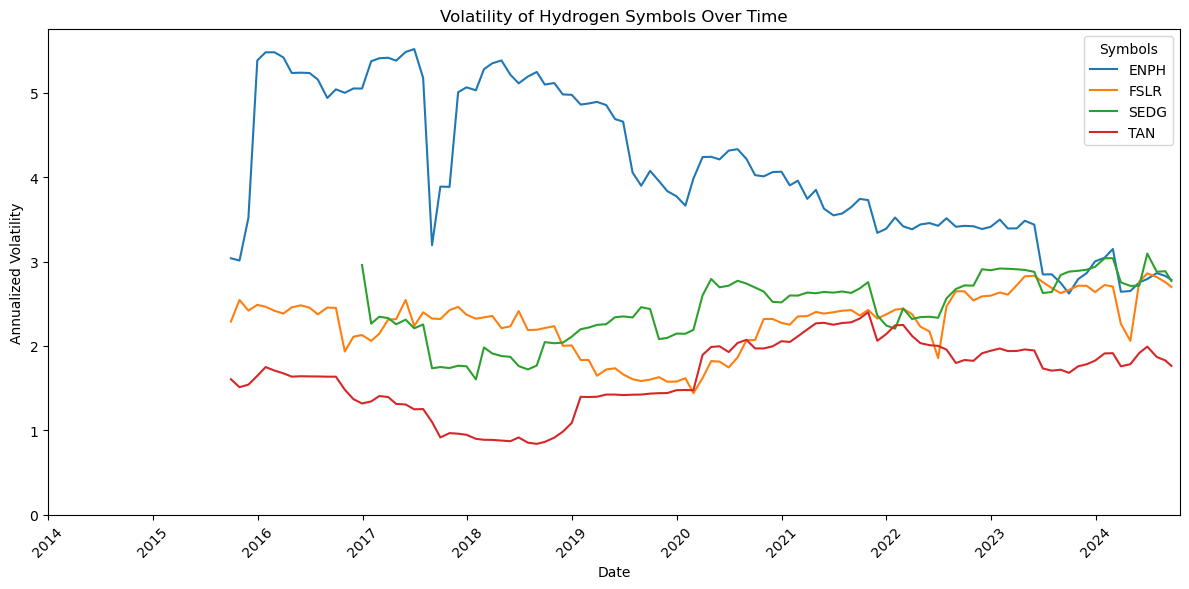

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate returns for each symbol
hydrogen_symbols_df['Returns'] = hydrogen_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
#window = 20
hydrogen_symbols_df['Volatility'] = hydrogen_symbols_df.groupby('Symbol')['Returns'].std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = solar_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')

volatility_df.index = pd.to_datetime(volatility_df.index)
# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Hydrogen Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.ylim(bottom=0)

years=mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax=plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)


plt.xlim(volatility_df.index.min() - pd.Timedelta(days=30),volatility_df.index.max() + pd.Timedelta(days=30))
plt.xticks(rotation=45) # Start y-axis at 0
plt.tight_layout()

#plt.grid(True)
plt.show()


In [12]:
# Ensure that the 'Date' column is in datetime format
ordered_data_df['Date'] = pd.to_datetime(ordered_data_df['Date'])


yearly_std = []

# Get unique company symbols
company_symbols = ordered_data_df['Symbol'].unique()

for symbol in company_symbols:
    # Get the starting year for the current symbol
    starting_year = ordered_data_df[ordered_data_df["Symbol"] == symbol]["Date"].dt.year.min()
    
    for year in range(starting_year, 2025):
        # Filter data for the current symbol and year
        yearly_data = ordered_data_df[(ordered_data_df["Symbol"] == symbol) & (ordered_data_df["Date"].dt.year == year)]
        
        # Calculate the standard deviation of the 'Closing Price'
        std = yearly_data["Closing Price"].std()
        
        # Append the result
        yearly_std.append({
            "Symbol": symbol,
            "Year": year,
            "Std for year": std,
            "Type": ordered_data_df.loc[ordered_data_df["Symbol"] == symbol, "Type"].iloc[0]
        })

# Create a DataFrame from the results
yearly_std_df = pd.DataFrame(yearly_std)

# Display the resulting DataFrame
yearly_std_df


,Symbol,Year,Std for year,Type
0,AMSC,2014,0.355345,Wind
1,AMSC,2015,1.992948,Wind
2,AMSC,2016,1.257937,Wind
3,AMSC,2017,1.305376,Wind
4,AMSC,2018,1.944070,Wind
...,...,...,...,...
113,TPIC,2020,10.582643,Wind
114,TPIC,2021,14.278840,Wind
115,TPIC,2022,2.524080,Wind
116,TPIC,2023,4.454690,Wind


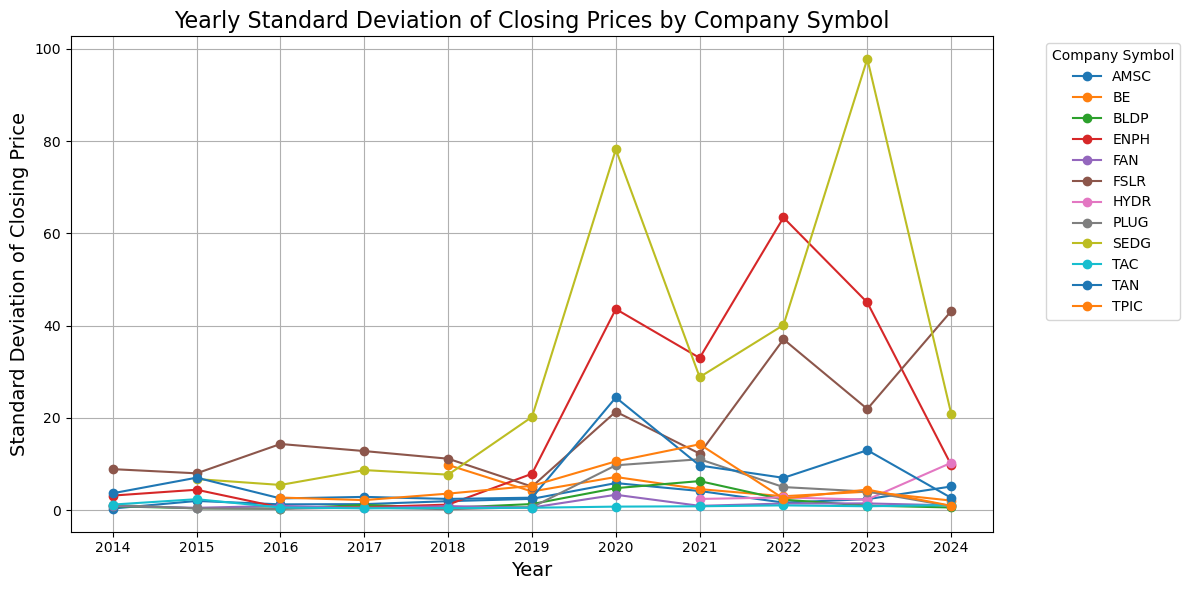

<Figure size 640x480 with 0 Axes>

In [13]:
# Create a line plot for the yearly standard deviation
plt.figure(figsize=(12, 6))
for symbol in yearly_std_df['Symbol'].unique():
    symbol_data = yearly_std_df[yearly_std_df['Symbol'] == symbol]
    plt.plot(symbol_data['Year'], symbol_data['Std for year'], marker='o', label=symbol)

# Adding titles and labels
plt.title('Yearly Standard Deviation of Closing Prices by Company Symbol', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Standard Deviation of Closing Price', fontsize=14)
# Set x-ticks to show each year
plt.xticks(range(yearly_std_df['Year'].min(), 2025))  
plt.legend(title='Company Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()
#plt.savefig('Yearly_Std_company_symbol.png')



**Analysis:**
- This graph illustrates the closing price volatility for various companies from 2014 to 2024, revealing several notable trends. Between 2014 and 2018, most companies maintained relatively low and stable volatility levels. However, a significant shift occurred in 2019 and 2020, with numerous firms experiencing a marked increase in volatility, possibly due to economic disruptions such as the COVID-19 pandemic. 
- Among the companies represented, SEDG (likely SolarEdge) stands out as the most volatile, showing dramatic spikes in 2019, 2020, and 2022. While some companies like AMSC and BE have shown increased volatility in recent years, others have managed to maintain more consistent stability throughout the period. 
- Interestingly, as we approach 2024, the volatility for most companies appears to be on a downward trend, potentially signaling a move towards greater market stability. This comprehensive view of price volatility across different firms offers valuable insights into market dynamics and individual company performance over the past decade.

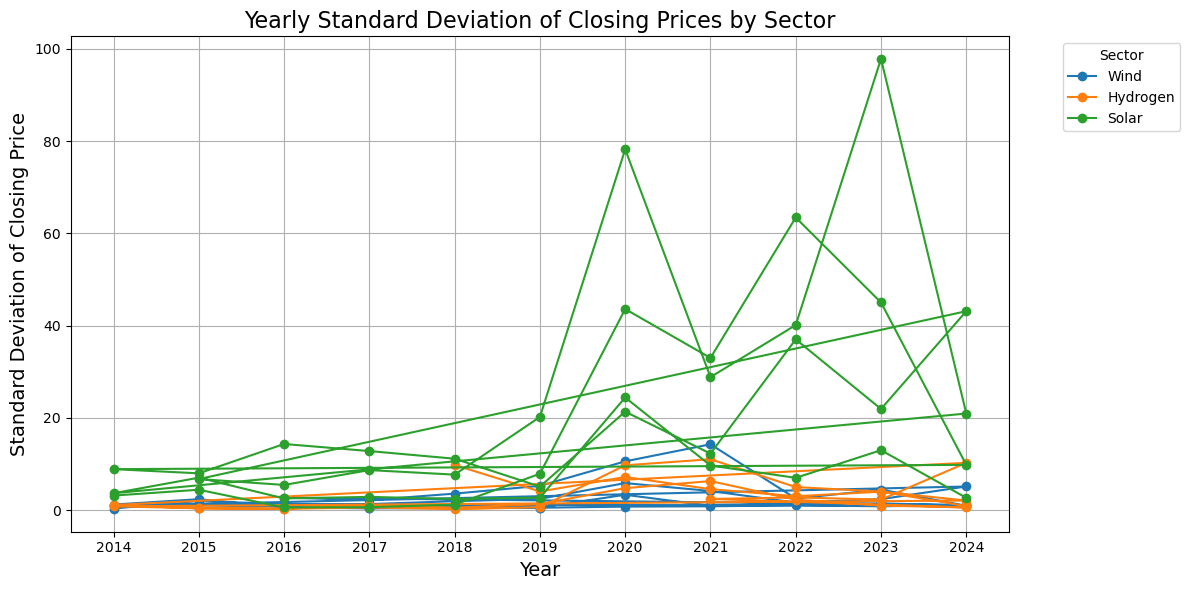

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(12, 6))
for symbol in yearly_std_df['Type'].unique():
    symbol_data = yearly_std_df[yearly_std_df['Type'] == symbol]
    plt.plot(symbol_data['Year'], symbol_data['Std for year'], marker='o', label=symbol)

# Adding titles and labels
plt.title('Yearly Standard Deviation of Closing Prices by Sector', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Standard Deviation of Closing Price', fontsize=14)
plt.xticks(range(yearly_std_df['Year'].min(), 2025))  # Set x-ticks to show each year
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()
#plt.savefig('Type.png')


**Analysis:**

The volatility of closing prices in many renewable energy industries is compared in this graph between 2014 and 2024. 

**Important realizations:**

- The most volatile industry overall is the solar sector, which had notable peaks in 2019 and 2020 as well as in 2022 and 2023.

- Over the course of the time, the wind and hydrogen sectors exhibit comparatively lower and more steady volatility.

- From 2018 to 2019, all sectors exhibit more volatility, perhaps as a result of changes in the business or world events.

- The tidal sector has shown to have the least amount of volatility overall, being steady over time.

- There is a convergence in sectoral volatility by 2024, indicating a potential stability or maturing of the industry.

Overall, the two graphs demonstrate that there were significant price fluctuations in the renewable energy sector between 2019 and 2023, with the largest fluctuations occurring in the solar sector and solar-related businesses. Even while volatility is considerably higher than it was in the first half of the decade, the data indicates a trend of stability by 2024.
